In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Data Pre-processing

In [31]:
class DataPreprocessing:
    def __init__(self, data_dir, img_size=65):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # Define transformations for training (with augmentation)
        self.train_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(40),
            transforms.RandomAffine(0, scale=(0.8, 1.2), shear=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Define transformations for validation (no augmentation)
        self.val_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def load_data(self):
        # Load full dataset with training transforms
        full_dataset = datasets.ImageFolder(self.data_dir, transform=self.train_transforms)
        
        # Split into train and validation sets
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
        
        # Update validation set with appropriate transforms
        val_dataset.dataset.transform = self.val_transforms
        
        return train_dataset, val_dataset

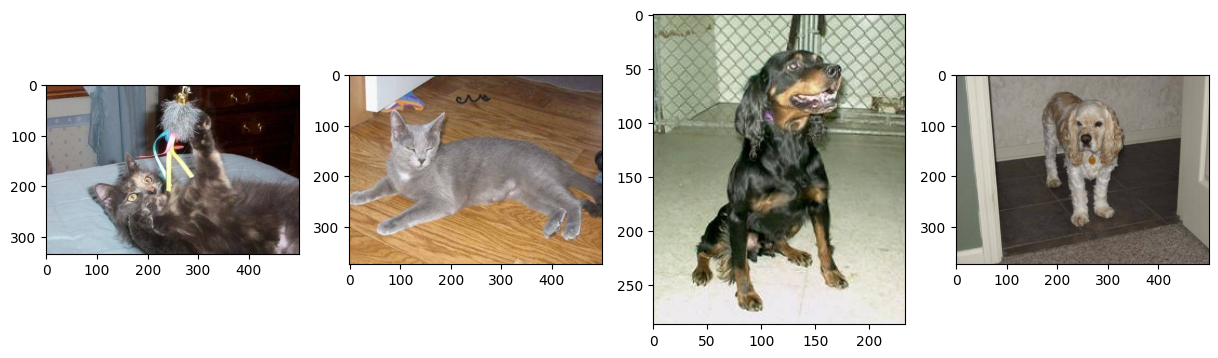

In [32]:
DATASET_FOLDER = 'datasets/train'

# Load and display images
cat_images = []
dog_images = []

# Load cat images
for filename in os.listdir(os.path.join(DATASET_FOLDER, 'cat')):
    if filename.endswith('.jpg'):  # Check if the file is a .jpg
        img_path = os.path.join(DATASET_FOLDER, 'cat', filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)  # Load image using Pillow
            cat_images.append(img)
            if len(cat_images) >= 2:  # Limit to 2 cat images
                break

# Load dog images
for filename in os.listdir(os.path.join(DATASET_FOLDER, 'dog')):
    if filename.endswith('.jpg'):  # Check if the file is a .jpg
        img_path = os.path.join(DATASET_FOLDER, 'dog', filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)  # Load image using Pillow
            dog_images.append(img)
            if len(dog_images) >= 2:  # Limit to 2 dog images
                break

# Combine images for display
images = cat_images + dog_images

# Display images in their original size
plt.figure(figsize=(15, 10))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)  # Directly use the Pillow image
    plt.axis('on')  # Show axis
plt.show()

Within the folder, there are more than 10k images for both cats and dogs

Now we need to convert the image into same size to enable the model to analyze later.

Let's create a folder called train in the root directory and combine both picture of cats and dogs after the image resize

In [33]:
DATASET_FOLDER = 'datasets/train'
OUTPUT_FOLDER = 'train'

# Create the output folder if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Resize and save all images from a given folder
def resize_and_save_all_images(folder_name, output_folder):
    count = 0  # Initialize counter
    for filename in os.listdir(os.path.join(DATASET_FOLDER, folder_name)):
        if filename.endswith('.jpg'):  # Check if the file is a .jpg
            img_path = os.path.join(DATASET_FOLDER, folder_name, filename)
            if os.path.isfile(img_path):
                img = Image.open(img_path)  # Load image using Pillow
                img_resized = img.resize((256, 256))  # Resize image to 64x64
                img_resized.save(os.path.join(output_folder, f"{folder_name}_{count}.jpg"))  # Save resized image
                count += 1  # Increment count only after saving a valid image

# Resize and save all cat and dog images
resize_and_save_all_images('cat', OUTPUT_FOLDER)
resize_and_save_all_images('dog', OUTPUT_FOLDER)

print("All images resized and saved successfully.")

All images resized and saved successfully.


Now, Let's see our new images

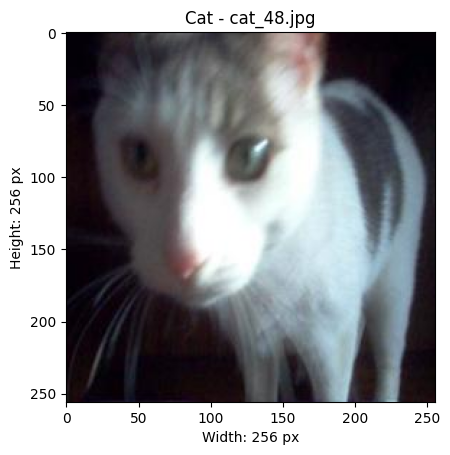

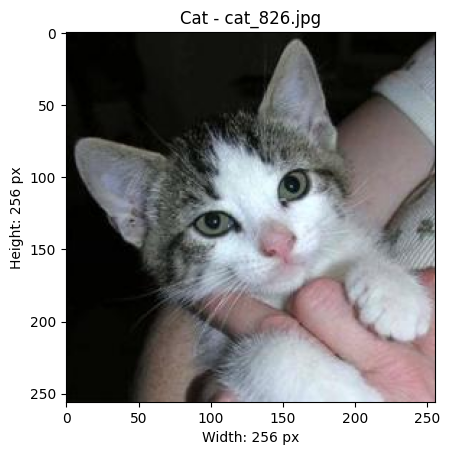

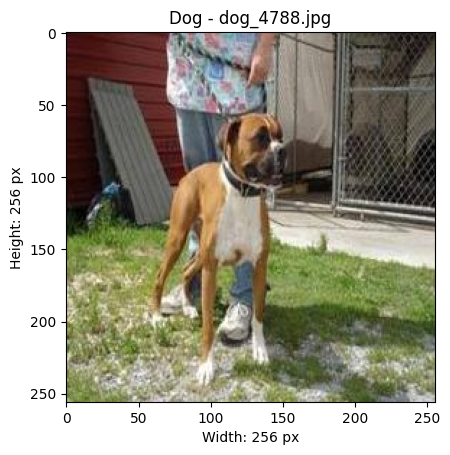

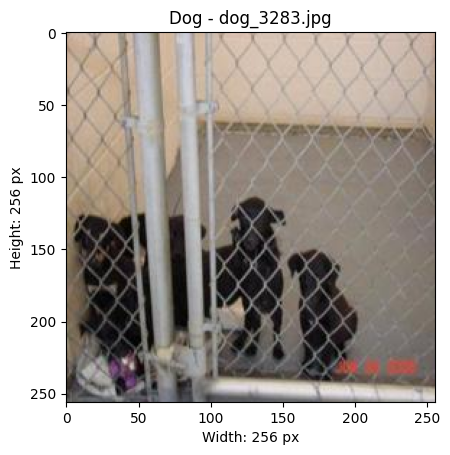

In [34]:
NEW_FOLDER = 'train'

# Function to display images with pixel dimensions
def display_images(category, num_images=2):
    images_shown = 0
    for filename in os.listdir(NEW_FOLDER):
        if filename.startswith(category) and filename.endswith('.jpg'):
            img_path = os.path.join(NEW_FOLDER, filename)
            img = Image.open(img_path)
            
            # Display image with axis showing pixel dimensions
            plt.imshow(img)
            plt.title(f"{category.capitalize()} - {filename}")
            plt.axis("on")
            plt.xlabel(f"Width: {img.width} px")
            plt.ylabel(f"Height: {img.height} px")
            plt.show()
            
            images_shown += 1
            if images_shown >= num_images:
                break

# Display 2 resized cat images
display_images('cat', num_images=2)

# Display 2 resized dog images
display_images('dog', num_images=2)

Now we can see each image will consist of 64x64 px.

Now we will convert this image into numerical data. the idea is to convert each pixels into 3 values representing rgb colors

image augmentation

In [35]:
# Set the data directory and image size
data_dir = "train"
img_size = 256


# Define transformations for augmentation
augmentation_transforms = [
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, scale=(0.5, 1.2), shear=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
]

# Apply transformations to each image in the directory
def augment_and_save_images(data_dir, img_size=256):
    transform = transforms.Compose(augmentation_transforms)
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("RGB")
            
            # Apply augmentation
            augmented_img = transform(img)
            
            # Save with "_aug" suffix in the same folder
            base_filename = filename.split('.')[0]  # Remove file extension
            new_filename = f"{base_filename}_aug.jpg"
            augmented_img_path = os.path.join(data_dir, new_filename)
            augmented_img.save(augmented_img_path)

            

# Run the augmentation function
augment_and_save_images(data_dir, img_size)
print(f"Saved augmented image")


Saved augmented image


Let's see the image aug

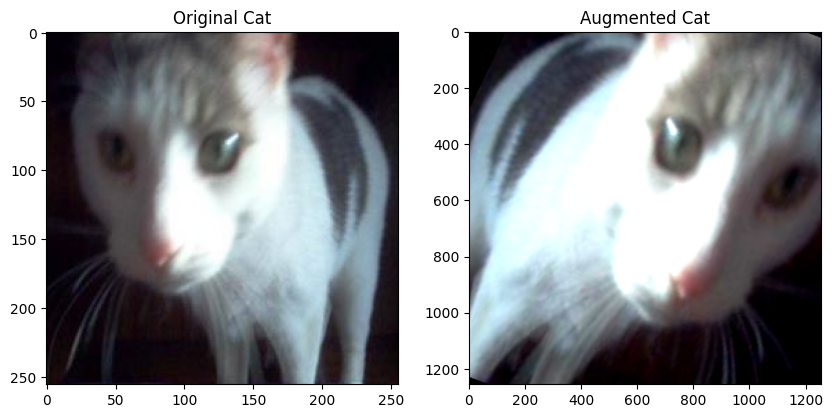

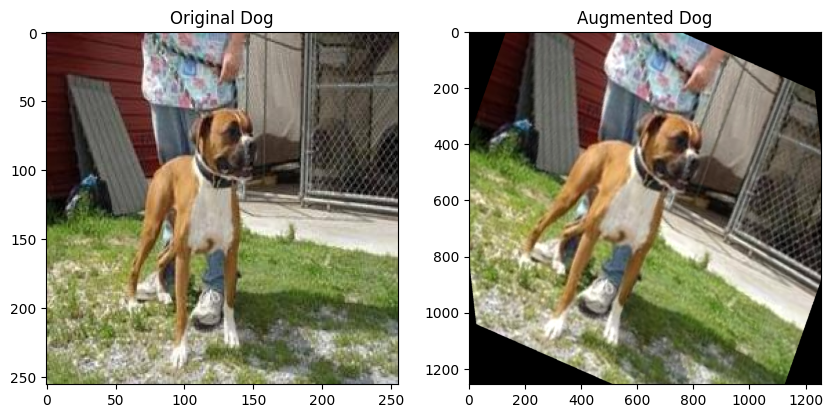

In [36]:
# Set the data directory and image size
data_dir = "train"
img_size = 1256

# Define transformations for augmentation
augmentation_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, scale=(0.8, 1.2), shear=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Function to apply augmentation and show images side-by-side
def show_original_and_augmented(data_dir, category, img_size=256):
    # Find a sample image
    for filename in os.listdir(data_dir):
        if filename.startswith(category) and filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("RGB")
            
            # Apply augmentation
            augmented_img = augmentation_transforms(img)
            
            # Plot original and augmented images side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img)
            axes[0].set_title(f"Original {category.capitalize()}")
            axes[0].axis("on")
            axes[1].imshow(augmented_img)
            axes[1].set_title(f"Augmented {category.capitalize()}")
            axes[1].axis("on")
            plt.show()
            
            break  # Show only one image for each category

# Display one cat and one dog image, along with their augmented versions
show_original_and_augmented(data_dir, 'cat', img_size)
show_original_and_augmented(data_dir, 'dog', img_size)


Now, we convert every image into rgb and store into a csv file

In [37]:
# Initialize a list to hold the image data and labels
data = []
labels = []

# Loop through the images in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path).convert("RGB")  # Open image as RGB
        
        img_array = np.array(img)  # Convert image to NumPy array
        
        # Append image data (as a list) and label (0 for cat, 1 for dog)
        data.append(img_array)
        
        # Set the label based on the filename
        if filename.startswith("dog"):
            labels.append(1)
        elif filename.startswith("cat"):
            labels.append(0)

# Create a DataFrame with the image data and labels
df = pd.DataFrame({
    'pixels': data,
    'label': labels
})

In [38]:
df.head(5)

,pixels,label
0,"[[[59, 17, 19], [60, 18, 20], [60, 18, 19], [6...",1
1,"[[[181, 162, 147], [170, 151, 136], [175, 156,...",1
2,"[[[3, 0, 7], [3, 0, 7], [3, 0, 7], [3, 0, 7], ...",0
3,"[[[170, 156, 147], [195, 181, 172], [194, 180,...",1
4,"[[[7, 7, 5], [6, 6, 4], [5, 5, 3], [5, 5, 3], ...",0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [40]:
print(df['pixels'][0].shape) # Shape for the pixels

(256, 256, 3)


In [41]:
df.to_pickle('train_256.pkl')

# -------------------------------------

### Training Arc

#### Tensor Convert

In [105]:
df = pd.read_pickle('train.pkl')

In [106]:
df.head()

,pixels,label
0,"[[[62, 12, 13], [63, 13, 14], [65, 14, 13], [6...",1
1,"[[[193, 170, 154], [204, 181, 163], [210, 187,...",1
2,"[[[0, 1, 6], [1, 2, 7], [3, 0, 7], [1, 0, 5], ...",0
3,"[[[169, 159, 149], [178, 168, 158], [182, 172,...",1
4,"[[[2, 2, 0], [2, 2, 0], [2, 2, 0], [2, 2, 0], ...",0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [68]:
# 1. Load DataFrame
# First column is the pixel values, second column is the label
pixel_data = np.array(df['pixels'].tolist())  # Convert to numpy array
labels = np.array(df['label'].tolist())  # Assuming 'label' is the second column

# Convert the pixel data to a tensor and ensure the right shape
X = torch.tensor(pixel_data, dtype=torch.float32)  # Shape: (num_samples, 3, 64, 64)
X = X.permute(0, 3, 1, 2)  # Now the shape will be (num_samples, 3, 64, 64)
y = torch.tensor(labels, dtype=torch.float32)  # Shape: (num_samples,)

# Create a TensorDataset
dataset = TensorDataset(X, y)

In [69]:
print("Shape of X (pixel data):", X.shape)  # Should print: (40000, 3, 64, 64)
print("Shape of y (labels):", y.shape)        # Should print: (40000)
print("Number of samples in the dataset:", len(dataset))

Shape of X (pixel data): torch.Size([40000, 3, 64, 64])
Shape of y (labels): torch.Size([40000])
Number of samples in the dataset: 40000


#### Model Architecture

In [70]:
# CNN Model Architecture
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input channels set to 3 for RGB
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            # Second Convolutional Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            # Third Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        
        # Calculate size of flattened features after the convolutional layers
        self.flatten_size = 128 * (64 // (2**3)) * (64 // (2**3))  # Adjusted for 64x64 images
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [71]:
# DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

#### Training Arc Begins Hmmmmm......

In [72]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [73]:
model = CatDogCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 20

In [74]:
for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


Epoch 1/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 322.96it/s]


Train Loss: 0.5998, Train Acc: 67.97%

Epoch 2/20


Training: 100%|██████████| 1250/1250 [00:05<00:00, 221.57it/s]


Train Loss: 0.4865, Train Acc: 76.61%

Epoch 3/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 402.24it/s]


Train Loss: 0.4329, Train Acc: 79.78%

Epoch 4/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 400.25it/s]


Train Loss: 0.3962, Train Acc: 82.05%

Epoch 5/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 405.81it/s]


Train Loss: 0.3698, Train Acc: 83.32%

Epoch 6/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 404.12it/s]


Train Loss: 0.3535, Train Acc: 84.11%

Epoch 7/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 383.08it/s]


Train Loss: 0.3281, Train Acc: 85.64%

Epoch 8/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 380.49it/s]


Train Loss: 0.3149, Train Acc: 86.21%

Epoch 9/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 391.37it/s]


Train Loss: 0.2924, Train Acc: 87.22%

Epoch 10/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 403.50it/s]


Train Loss: 0.2809, Train Acc: 87.80%

Epoch 11/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 379.87it/s]


Train Loss: 0.2719, Train Acc: 88.29%

Epoch 12/20


Training: 100%|██████████| 1250/1250 [00:05<00:00, 215.13it/s]


Train Loss: 0.2601, Train Acc: 88.86%

Epoch 13/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 374.30it/s]


Train Loss: 0.2503, Train Acc: 89.53%

Epoch 14/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 382.99it/s]


Train Loss: 0.2355, Train Acc: 90.05%

Epoch 15/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 372.18it/s]


Train Loss: 0.2319, Train Acc: 90.31%

Epoch 16/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 399.35it/s]


Train Loss: 0.2202, Train Acc: 90.64%

Epoch 17/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 416.59it/s]


Train Loss: 0.2137, Train Acc: 91.17%

Epoch 18/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 403.13it/s]


Train Loss: 0.2077, Train Acc: 91.42%

Epoch 19/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 406.38it/s]


Train Loss: 0.1972, Train Acc: 91.84%

Epoch 20/20


Training: 100%|██████████| 1250/1250 [00:03<00:00, 412.07it/s]

Train Loss: 0.1940, Train Acc: 92.05%


# ------------------------------------

### Final Boss

#### Test Data Preparation

In [47]:
DATASET_FOLDER = 'datasets/val'
OUTPUT_FOLDER = 'test'

# Create the output folder if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Resize and save all images from a given folder
def resize_and_save_all_images(folder_name, output_folder):
    count = 0  # Initialize counter
    for filename in os.listdir(os.path.join(DATASET_FOLDER, folder_name)):
        if filename.endswith('.jpg'):  # Check if the file is a .jpg
            img_path = os.path.join(DATASET_FOLDER, folder_name, filename)
            if os.path.isfile(img_path):
                img = Image.open(img_path)  # Load image using Pillow
                img_resized = img.resize((256, 256))  # Resize image to 64x64
                img_resized.save(os.path.join(output_folder, f"{folder_name}_{count}.jpg"))  # Save resized image
                count += 1  # Increment count only after saving a valid image

# Resize and save all cat and dog images
resize_and_save_all_images('cat', OUTPUT_FOLDER)
resize_and_save_all_images('dog', OUTPUT_FOLDER)

print("All images resized and saved successfully.")

All images resized and saved successfully.


In [48]:
# Set the data directory and image size
data_dir = "test"
img_size = 256

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()  # Convert to tensor if needed
])

# Initialize a list to hold the image data and labels
data = []
labels = []

# Loop through the images in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path).convert("RGB")  # Open image as RGB
        
        img_array = np.array(img)  # Convert image to NumPy array
        
        # Append image data (as a list) and label (0 for cat, 1 for dog)
        data.append(img_array)
        
        # Set the label based on the filename
        if filename.startswith("dog"):
            labels.append(1)
        elif filename.startswith("cat"):
            labels.append(0)

# Create a DataFrame with the image data and labels
df_test = pd.DataFrame({
    'pixels': data,
    'label': labels
})

In [49]:
df_test.head()

,pixels,label
0,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",0
1,"[[[213, 173, 112], [213, 173, 112], [214, 174,...",0
2,"[[[56, 51, 31], [58, 53, 31], [58, 54, 27], [5...",0
3,"[[[142, 136, 112], [112, 106, 82], [113, 108, ...",1
4,"[[[55, 67, 81], [57, 69, 83], [59, 71, 87], [5...",0


In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [51]:
print(df_test['pixels'][0].shape) # Shape for the pixels

(256, 256, 3)


In [ ]:
df_test.to_pickle('test_256.pkl')

: 

#### Model Preparation

In [108]:
test_df = pd.read_pickle('test.pkl')
test_df.head()

,pixels,label
0,"[[[2, 4, 3], [2, 4, 3], [2, 4, 3], [1, 3, 2], ...",0
1,"[[[229, 177, 101], [223, 174, 98], [227, 180, ...",0
2,"[[[57, 59, 37], [52, 54, 33], [18, 19, 5], [10...",0
3,"[[[84, 92, 79], [77, 84, 68], [156, 161, 141],...",1
4,"[[[48, 64, 80], [65, 81, 97], [57, 70, 86], [6...",0


In [109]:
# Convert to numpy arrays
test_pixel_data = np.array(test_df['pixels'].tolist())  # Convert pixel values to numpy array
test_labels = np.array(test_df['label'].tolist())  # Assuming 'label' is the second column

# Convert pixel data to tensor
X_test = torch.tensor(test_pixel_data, dtype=torch.float32)  # Shape: (num_samples, 3, 64, 64)
X_test = X_test.permute(0, 3, 1, 2)
y_test = torch.tensor(test_labels, dtype=torch.float32)  # Shape: (num_samples,)

# Create a TensorDataset
test_dataset = TensorDataset(X_test, y_test)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Model Evaluation

In [110]:
# model = CatDogCNN()  # Make sure to initialize the model
# model.load_state_dict(torch.load('cat_dog_classifier.pth'))  # Load the trained model weights
model.eval()

CatDogCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p

In [112]:
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Thresholding at 0.5
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device
final_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device)


print(f"Final Model Accuracy on Test Dataset: {final_accuracy:.2f}%")

Final Model Accuracy on Test Dataset: 88.52%
